<div class='wrn' style='font-weight:700;font-size:18px;'>This notebook should be viewed on <a href='https://nbviewer.jupyter.org'>nbviewer.jupyter.org</a> to render properly.</div>

In [1]:
from IPython.core.display import HTML
HTML('<link href="https://fonts.googleapis.com/css2?family=IBM+Plex+Sans:ital,wght@0,400;0,500;0,700;1,400;1,500;1,700&display=swap" rel="stylesheet">')

In [2]:
import urllib
response = urllib.request.urlopen("https://gist.githubusercontent.com/sgttwld/9deff60facb16918e54410cca3d65648/raw")
css = str(response.read().decode("utf-8"))
HTML("<style type='text/css'>"+css+"</style>")

In [3]:
%config InlineBackend.figure_format = 'retina'

In [4]:
# imports
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import tensorflow as tf
from RD_GD import GD
from RD_MA import MA
from RD_FC import RDFC
import os, time
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' 

In [5]:
# plot settings
sns.reset_defaults()
sns.set(
    rc={
        'figure.figsize': (7,3),
        'axes.titlesize': 10,
        'axes.labelsize': 10,
        'legend.fontsize': 9,
        'xtick.labelsize': 8,
        'ytick.labelsize': 8,
        'axes.spines.top': False,
        'axes.spines.right': False,
        
    }, 
    style="white" 
)
sns.set_palette(sns.cubehelix_palette(5,start=.9,rot=-.1))

In [6]:
def legend_string(r):
    return ['beta={}\nN={}\n{} iterations\n{:.2f} seconds\nR={:.3f}\nD={:.5f}'.format(
        r['beta'],len(r['xhat']),r['episodes'],r['elapsed'],r['rate'],r['distortion'])]

In [7]:
def get_source(num):
    return tf.constant( np.random.beta(a=1,b=2,size=(num)) ) 

# Rate-distortion with fixed cardinality (RDFC): _a combination of Blahut-Arimoto and the mapping approach_

In [Banerjee et al. (2004)](http://www.cs.utexas.edu/~inderjit/public_papers/icml04breg.pdf) the authors describe a rate-distortion variant they call _rate-distortion with fixed cardinality_ (RTFC), which they define as the optimization problem
$$
\min_{\scriptsize\begin{array}{c}\hat{\mathcal{X}}, q(\hat{X}|X),\\[-2pt] s.t. \ |\hat{\mathcal X}|=N\end{array}} \Big[ \mathbb E[d(X,\hat X)] + \tfrac{1}{\beta} I(X;\hat X) \Big]
$$
which modifies the original Shannon rate-distortion problem by not only optimizing over $q(\hat X|X)$ but also over the support set $\hat{\mathcal X}$ of $\hat X$, which is constrained to have cardinality $N$, i.e. $|\hat{\mathcal{X}}|=N$. 

We have implemented ([RD_FC.py](https://github.com/sgttwld/rate-distortion-with-fixed-cardinality/blob/master/RD_FC.py)) the alternating optimization algorithm by Banerjee et al., consisting of a combination of the _Blahut-Arimoto algorithm_ and the support reestimation step of the _mapping approach_ by Rose.

In [8]:
num = 5000
beta = 100

## Results for a given inverse temperature
Here we consider a set of iid samples of a continuous source $X$ distributed according to a Beta distribution, 

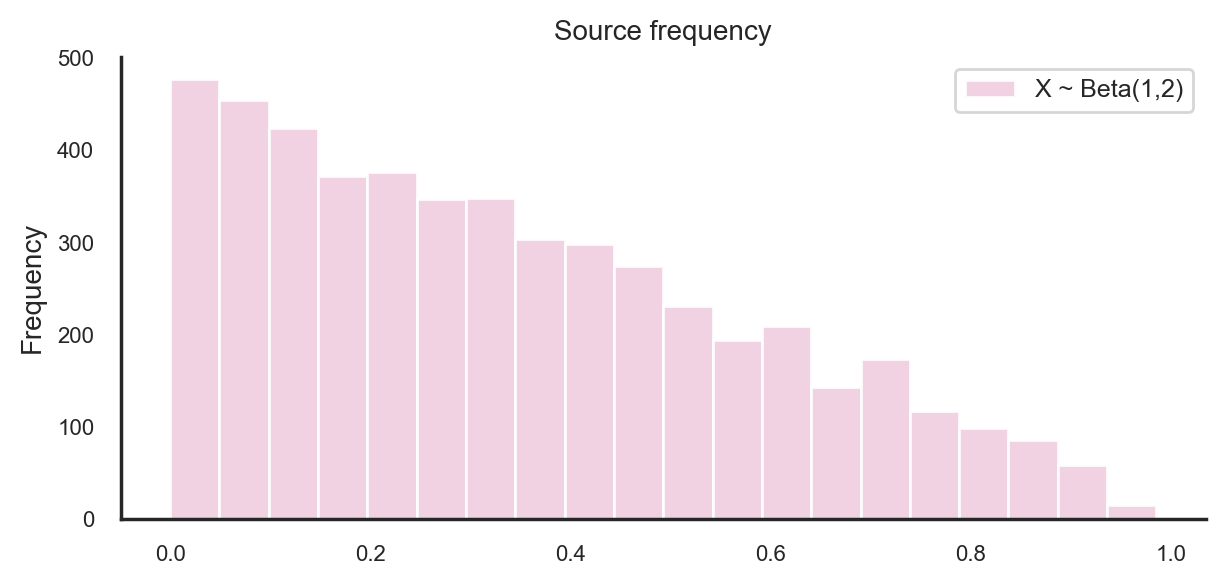

In [9]:
X = get_source(num)
ax = pd.DataFrame(X).plot.hist(bins=20,alpha=.9,fontsize=8,title='Source frequency')
ax.legend([r'X ~ Beta(1,2)'])
plt.show()

Before showing at the results of RDFC, it is instructive to have a look at the results of standard rate-distortion algorithms.

### _Optimal reconstruction distribution_ ([RD_GD.py](https://github.com/sgttwld/rate-distortion-with-fixed-cardinality/blob/master/RD_FC.py))
Shannon's rate-distortion trade-off 
$$
\min_{q(\hat X|X)} \Big[ \mathbb E[d(X,\hat X)] + \tfrac{1}{\beta} I(X;\hat X) \Big]
$$
for the above sample set, e.g. calculated using the Blahut-Arimoto algorithm or gradient descent, produces a marginal distribution $q(\hat X)= E_X[q(\hat X|X)]$ of the approximate form:

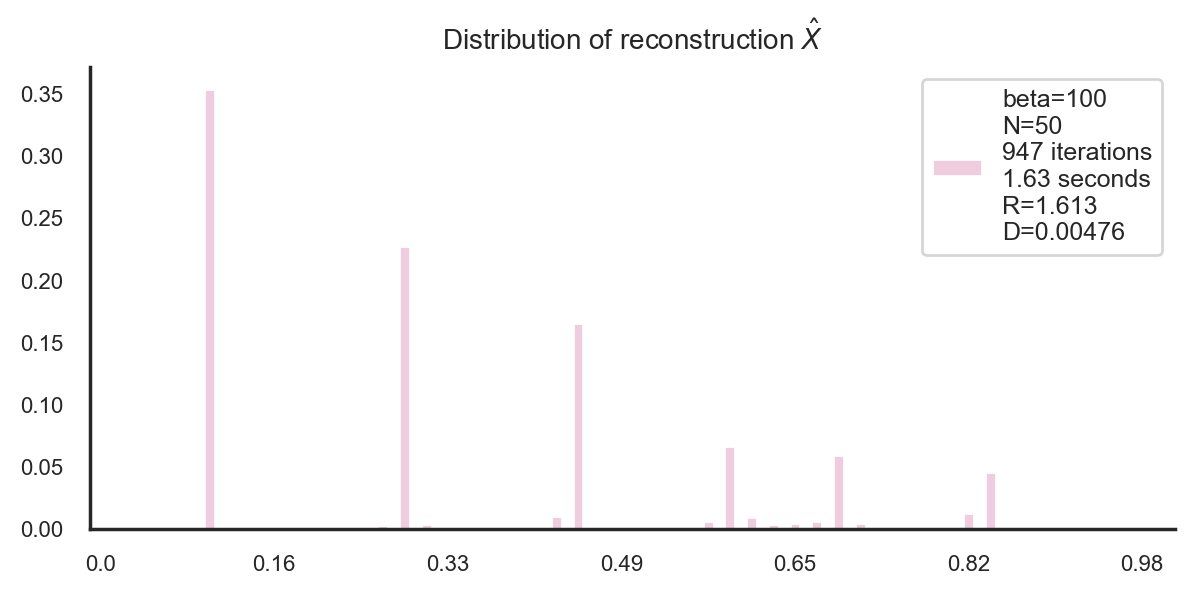

In [10]:
r = GD(X,np.array([beta]),N=50)[0]
ax = pd.DataFrame(r['q']).plot.bar(title=r'Distribution of reconstruction $\hat{X}$',rot=0)
ax.legend(legend_string(r))
xticks = np.arange(0,len(r['q']),8)
plt.xticks(xticks,np.round(r['xhat'],2)[xticks])
plt.show()

### _Mapping approach_ ([RD_MA.py](https://github.com/sgttwld/rate-distortion-with-fixed-cardinality/blob/master/RD_MA.py))

In the [mapping approach by Rose](https://ieeexplore.ieee.org/document/340468), the rate-distortion Lagrangian is written as an expectation over $q(\hat X)$, which then is represented by an integral over the unit interval $[0,1]$ (with respect to the Lebesgue measure), and where $\hat X$ is replaced by the value $y(u)$ of a mapping $y$ at $u\in[0,1]$. When discretizing $[0,1]$ into $N$ chunks, this results in an optimization over vectors $(y_i)_{i=1}^N$. In some cases (e.g. uniform source) the $y_i$ coincide with the values of $\hat X$ on which the optimal distribution $q(\hat X)$ has its support. However, in general, they are not necessarily related to this support set, but should be treated more like _integration points_ in numerical integration, which when $N$ is large enough and the $y_i$ are positioned correctly allows to write the integral (an expectation in this case) as a finite sum (see the [notebook on rate-distortion](https://nbviewer.jupyter.org/github/sgttwld/rate-distortion/blob/master/rate-distortion_nb.ipynb) for more details).

Nevertheless, by abusing notiation, we could write $\hat X \in \hat{\mathcal X}$ with $|\hat{\mathcal{X}}|=N$ for the components $y_i\in \{y_1,\dots,y_N\}$, so that the discretized mapping approach could be written as the optimization problem
$$
\min_{\scriptsize\begin{array}{c}\hat{\mathcal{X}}, s.t.\\[-2pt] |\hat{\mathcal X}|=N\end{array}}-\tfrac{1}{\beta} \mathbb E_X\Bigg[\log \tfrac{1}{N} \sum_{\hat x\in\hat{\mathcal{X}}} e^{-\beta d(X,\hat x)} \Bigg] =  \min_{\scriptsize\begin{array}{c}\hat{\mathcal{X}}, q(\hat{X}|X),\\[-2pt] s.t. \ |\hat{\mathcal X}|=N\end{array}} \Big[ \mathbb E[d(X,\hat X)] + \tfrac{1}{\beta} D_{KL}(q(\hat{X}|X)\|\tfrac{1}{N}) \Big]
$$  
In this form, the discretized mapping approach __almost coincides with the RDFC problem__, just that the mutual information between $X$ and $\hat X$ is replaced by the Kullback-Leibler divergence from the fixed uniform prior $\frac{1}{N}$ to $q(\hat X|X)$, i.e. the only difference is the non-optimality of the prior. 

With the same trade-off parameter as above, the mapping approach with $N=$ 20 discretization points yields:

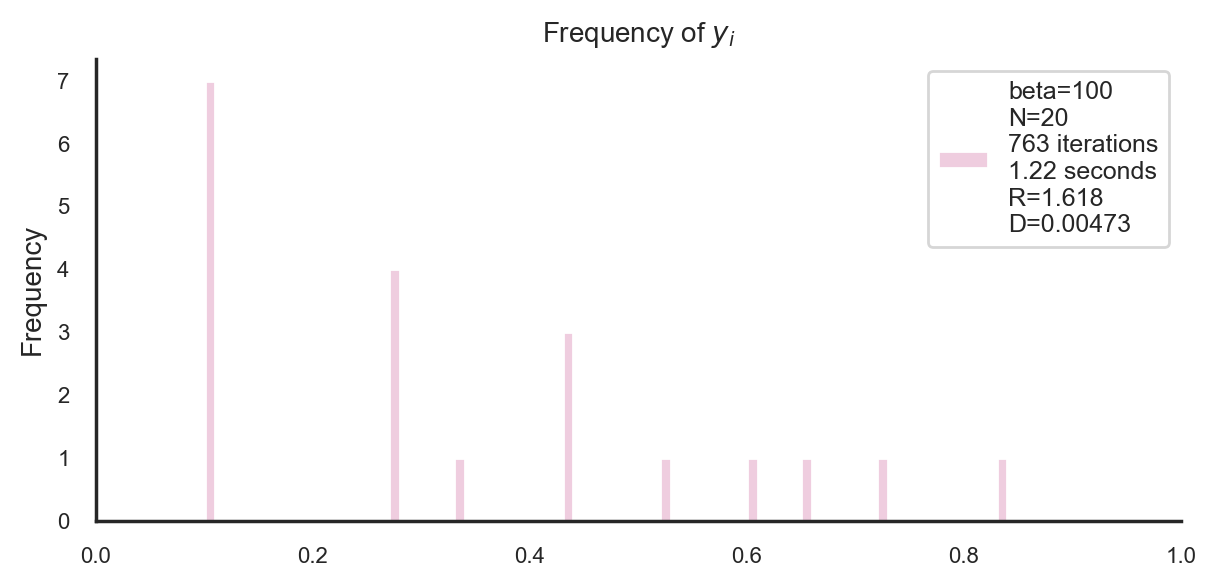

In [11]:
r = MA(X,np.array([beta]),N=20)[0]
ax = pd.DataFrame(r['xhat']).plot.hist(bins=100,range=(0,1),title=r'Frequency of $y_i$')
ax.legend(legend_string(r))
plt.xlim([0,1])
plt.show()

and with $N=6$:

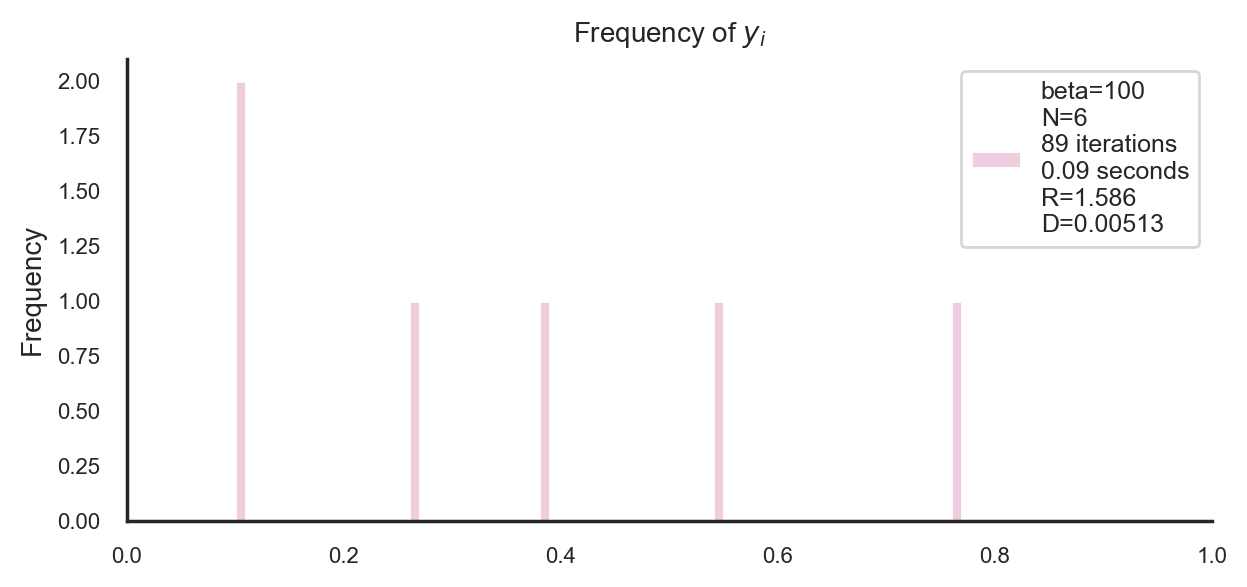

In [12]:
r = MA(X,np.array([beta]),N=6)[0]
ax = pd.DataFrame(r['xhat']).plot.hist(bins=100,range=(0,1),title=r'Frequency of $y_i$')
ax.legend(legend_string(r))
plt.xlim([0,1])
plt.show()

A downside of the mapping approach is that due to the uniform use of the discretization points $y_i$, one requires a relatively high number of them to adjust well to the source distribution. For example, for the trade-off parameter from above, the optimal rate-distortion curve is reached at about N=20:

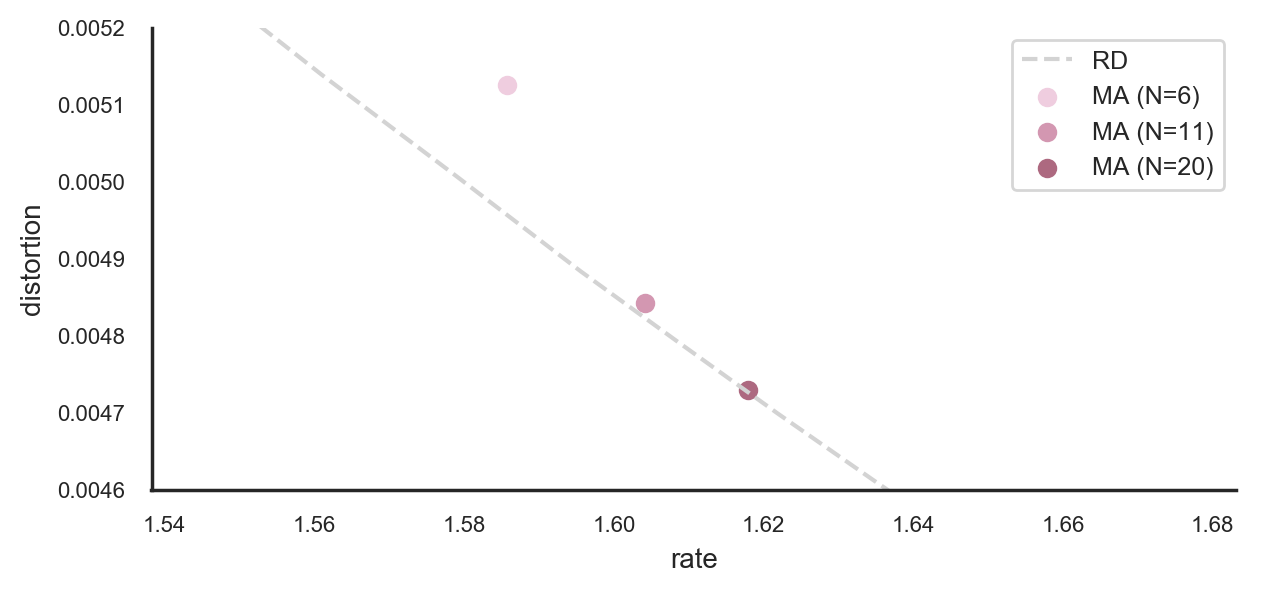

In [13]:
MA_points = [MA(X,np.array([100]),N=n) for n in [6,11,20]] 
df_GD = pd.DataFrame(GD(X,np.linspace(90,110,10),N=100))
plt.plot(df_GD['rate'],df_GD['distortion'],label='RD',color='lightgray',ls='--')
for r in MA_points:
    plt.scatter(r[0]['rate'],r[0]['distortion'],label='MA (N={})'.format(len(r[0]['xhat'])))
plt.legend()
plt.ylabel('distortion')
plt.xlabel('rate')
plt.ylim([0.0046,0.0052])
plt.show()

Of course, this in an improvement over the straightforward discretization of the range of $\hat X$ that for example yields the "optimal" reconstruction distribution shown above ($N=$ 50) and for the reference curve in this plot we used $N=$ 100. However, it turns out that RDFC, which essentially is a combination of these two approaches, can further improve on the number of required parameters in order to to reach the optimality bound given by the rate-distortion curve. 

### _RDFC_ ([RD_FC.py](https://github.com/sgttwld/rate-distortion-with-fixed-cardinality/blob/master/RD_FC.py))

The RDFC problem formally combines the original rate-distortion problem and the discretized mapping approach in that it optimizes the rate-distortion Lagrangian over the conditional probabilities $q(\hat X|X)$ which can be rewritten as an optimization over the distribution $q(\hat X)$ by substituting the Boltzmann distribution, but also optimizes over the support set of $q(\hat X)$, which in the mapping approach _replaces_ the optimization over $q(\hat X)$. Here, both are combined which results in an efficient way to calculate the rate-distortion trade-off by making use of the strengths of both approaches:

* __adaptive grid__: it allows to freely adapt the reconstruction points $\hat X\in \hat{\mathcal{X}}$ (strength of the mapping approach that allows to obtain optimal solutions despite of a finite number $N$ of discretization intervals)

* __adaptive distribution__: a non-uniform distribution $q(\hat X)$ over the reconstruction points allows that the reconstruction points can be used according to the source distribution (strength of the original rate-distortion problem)

One can also use a combination of the respective iterative solution algorithms to solve the RDFC problem (Algorithm 1 in [Banerjee et al. (2004)](http://www.cs.utexas.edu/~inderjit/public_papers/icml04breg.pdf)), consisting of (i) a _Blahut-Arimoto step_, which consists of calculating the Boltzmann distribution $q^\ast(\hat X|X)$ and the marginal $q^\ast(\hat X) = E_X[q(\hat X|X)]$, and (ii) of a _support re-estimation step_ which just like in the iterative mapping approach consists in a nearest-neighbour approximation (minimizing average distortion). In the case of the squared distance $d(s,t) = (t-s)^2$ (or any other Bregman divergence) this optimum is simply the conditional expectation of $X$ given the reconstruction point.  

With the same trade-off parameter as above and the low number of reconstruction points $N=$ 6, we obtain

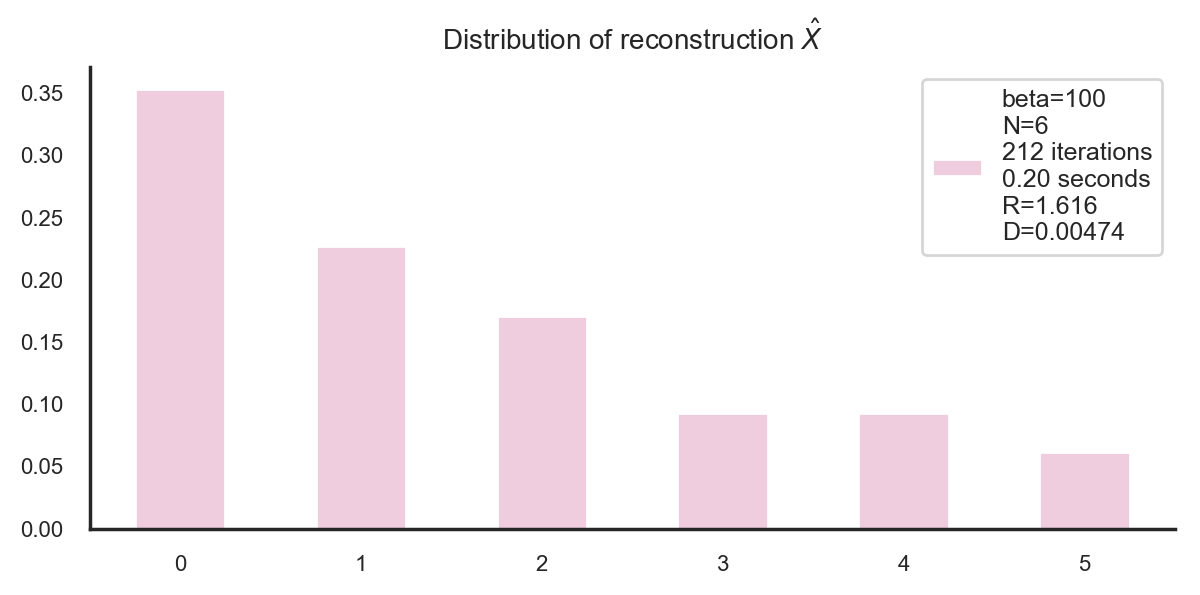

In [14]:
r = RDFC(X,np.array([beta]),N=6)[0]
ax = pd.DataFrame(r['q']).plot.bar(
    title=r'Distribution of reconstruction $\hat X$',rot=0,fontsize=8)
ax.legend(legend_string(r))
plt.show()

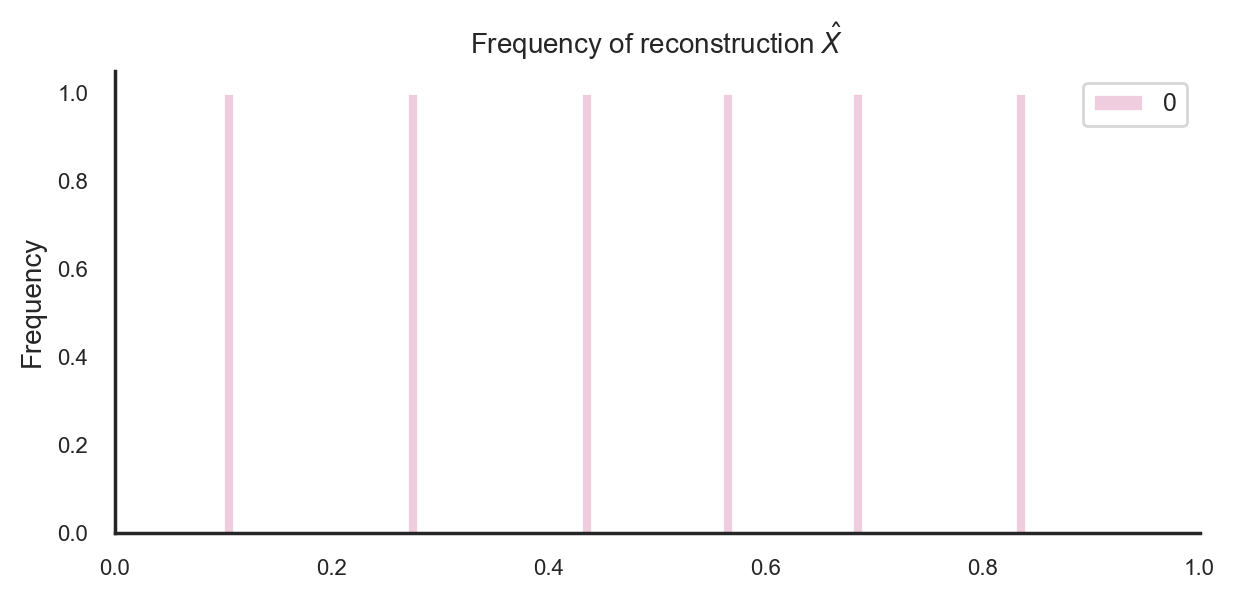

In [15]:
pd.DataFrame(r['xhat']).plot.hist(bins=100,range=(0,1),title=r'Frequency of reconstruction $\hat X$')
plt.xlim([0,1])
plt.show()

We can see how the work, which in the mapping approach has to be done solely by the position of the reconstruction points, is now spread over the choice of the reconstruction points _and_ their distribution. This way, we only need 11 independent parameters (6 positions and 5 independent probability values) to reach optimal rate-distortion performance: 

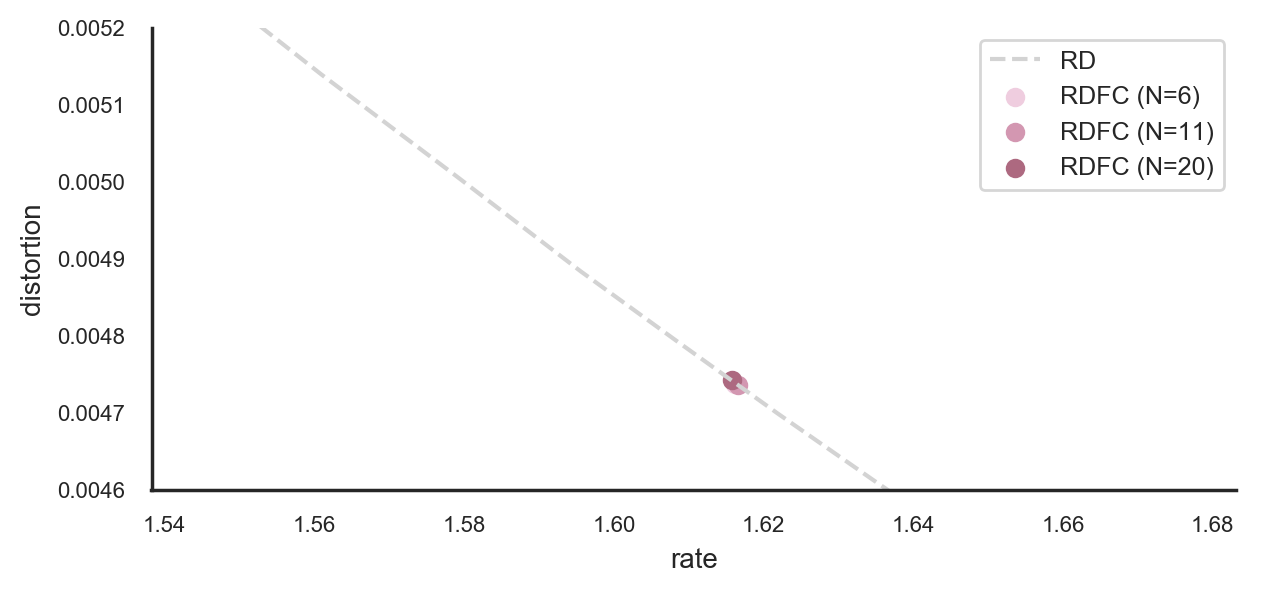

In [16]:
RDFC_points = [RDFC(X,np.array([100]),N=n) for n in [6,11,20]]
plt.plot(df_GD['rate'],df_GD['distortion'],label='RD',color='lightgray',ls='--')
for r in RDFC_points:
    plt.scatter(r[0]['rate'],r[0]['distortion'],label='RDFC (N={})'.format(len(r[0]['q'])))
plt.legend()
plt.ylabel('distortion')
plt.xlabel('rate')
plt.ylim([0.0046,0.0052])
plt.show()

## Rate-distortion curves for non-optimal cardinality
When constraining the cardinality of the reproduction support to a low number (here $N=$ 5), then RDFC can achieve optimality for longer (i.e. higher $\beta$) than the mapping approach, since it has the extra degrees of freedom given by the distribution $q(\hat X)$, which allows to make up for the lack of reproduction points by choosing them probabilistically: 

In [17]:
betas = np.linspace(60,400,20)
df_MA = pd.DataFrame(MA(X,betas,N=5))
df_RDFC = pd.DataFrame(RDFC(X,betas,N=5))
df_GD = pd.DataFrame(GD(X,betas,N=50))

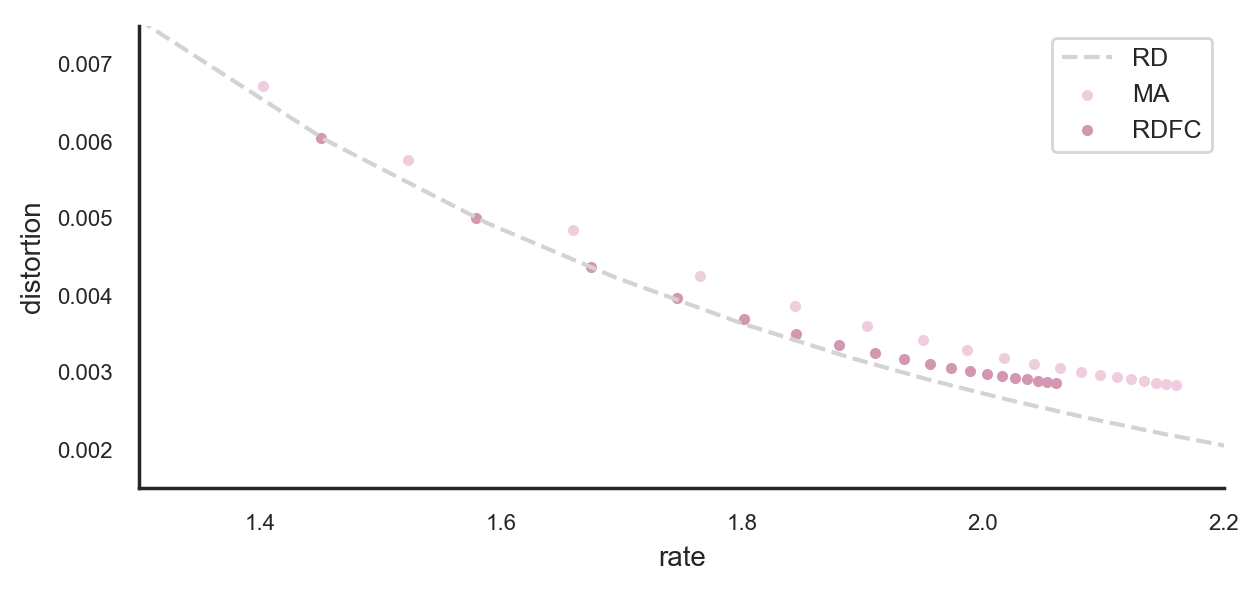

In [18]:
plt.plot(df_GD['rate'],df_GD['distortion'],label='RD',color='lightgray',ls='--')
plt.scatter(df_MA['rate'],df_MA['distortion'],label='MA',marker='.')
plt.scatter(df_RDFC['rate'],df_RDFC['distortion'],label='RDFC',marker='.')
plt.legend()
plt.ylabel('distortion')
plt.xlabel('rate')
plt.xlim([1.3,2.2])
plt.ylim([0.0015,0.0075])
plt.show()

<div class='name'>2020-05-28<br> <a href='https://gttwld.de'><i>Sebastian Gottwald</i></a></div>